<a href="https://colab.research.google.com/github/nyoons/ESAA/blob/main/Ch_08_%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%B6%84%EC%84%9D_%EA%B3%BC%EC%A0%9C4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**06. 토픽 모델링(Topic Modeling) - 20 뉴스그룹**
토픽 모델링 : 문서 집합(특히 많은 양의 문서가 있을 경우 머신러닝이 유용)에 숨어 있는 핵심 주제를 찾아내는 것. 머신러닝 기반의 토픽 모델은 중심 단어를 함축적으로 추출한다.

머신러닝 기반의 토픽 모델링에 자주 사용되는 기법은 LSA(Latent Semantic Analysis)와 LDA(Latent Dirichlet Allocation)이다. 여기서의 LDA =/= 차원축소의 LDA임을 유의.

20 뉴스그룹 데이터는 20가지의 주제를 갖고 있다. 이 중 모토사이클, 야구, 그래픽스, 윈도우, 중동, 기독교, 전자공학, 의학의 8개 주제를 추출하고 이들 텍스트에 LDA 기반의 토픽 모델링을 적용해보자.

LDA 토픽 모델링을 위한한 fetch_20newsgroups() API는 categories 파라미터를 통해 필요한 주제만 필터링해 추출하고 추출된 텍스트를 count 기반으로 벡터화한다.

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#8개 주제 추출
cats=['rec.motorcycles', 'rec.sport.baseball', 'comp.graphics', 'comp.windows.x', 'talk.politics.mideast', 'soc.religion.christian', 'sci.electronics', 'sci.med']

#위에서 cats 변수로 기재된 카테고리만 추출. fetch_20newsgroups()의 categories에 cats 입력.
news_df=fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), categories=cats, random_state=0)

#LDA는 count 기반의 벡터화만 적용한다
count_vect=CountVectorizer(max_df=0.95, max_features=1000, min_df=2, stop_words='english', ngram_range=(1,2))

feat_vect=count_vect.fit_transform(news_df.data)
print('CountVectorizer Shape:', feat_vect.shape)

CountVectorizer Shape: (7862, 1000)


feat_vect는 모두 7862개의 문서가 1000개의 피처로 구성된 행렬 데이터. 이렇게 피처 벡터화된 데이터 세트를 기반으로 LDA 토픽 모델링을 수행하자. LatentDirichletAllocation 클래스의 n_components 파라미터를 이용해 이 토픽 개수를 조정한다.

In [2]:
lda=LatentDirichletAllocation(n_components=8, random_state=0)
lda.fit(feat_vect)

LatentDirichletAllocation(n_components=8, random_state=0)

이렇게 수행한 결과 components_ 속성값을 가지게 되는데, components_는 개별 토픽별로 각 word 피처가 얼마나 많이 그 토픽에 할당되었는지를 나타낸다. 높은 값일수록 해당 word 피처는 그 토픽의 중심 word가 되는 것.

In [3]:
print(lda.components_.shape)
lda.components_

(8, 1000)


array([[3.60992018e+01, 1.35626798e+02, 2.15751867e+01, ...,
        3.02911688e+01, 8.66830093e+01, 6.79285199e+01],
       [1.25199920e-01, 1.44401815e+01, 1.25045596e-01, ...,
        1.81506995e+02, 1.25097844e-01, 9.39593286e+01],
       [3.34762663e+02, 1.25176265e-01, 1.46743299e+02, ...,
        1.25105772e-01, 3.63689741e+01, 1.25025218e-01],
       ...,
       [3.60204965e+01, 2.08640688e+01, 4.29606813e+00, ...,
        1.45056650e+01, 8.33854413e+00, 1.55690009e+01],
       [1.25128711e-01, 1.25247756e-01, 1.25005143e-01, ...,
        9.17278769e+01, 1.25177668e-01, 3.74575887e+01],
       [5.49258690e+01, 4.47009532e+00, 9.88524814e+00, ...,
        4.87048440e+01, 1.25034678e-01, 1.25074632e-01]])

8개의 토픽별로 1000개의 피처가 해당 토픽별로 연관도 값을 가지고 있다. components_array의 0번째 row, 10번째 col에 있는 값은 topic 0에 대해 피처 벡터화된 행렬에서 10번째 칼럼에 해당하는 피처가 topic 0에서 연관되는 수치를 갖는 것.

하지만 이렇게 보면 각 토픽별 word 연관도를 보기 어렵다. 토픽별로 연관도가 높은 순으로 word를 나열해주는 함수를 만들어보자.

In [12]:
def display_topics(model, feature_names, no_top_words):
  for topic_index, topic in enumerate(model.components_):
    print('Topic #', topic_index)

    #components_array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array 인덱스를 반환
    topic_word_indexes=topic.argsort()[::-1]
    top_indexes=topic_word_indexes[:no_top_words]

    #top_indexes 대상인 인덱스별로 feature_name에 해당하는 word feature 추출 후 join으로 concat
    feature_concat=' '.join([feature_names[i] for i in top_indexes])
    print(feature_concat)

#CountVectorizer 객체 내의 전체 word의 명칭을 get_features_names()를 통해 추출
feature_names=count_vect.get_feature_names_out()

#토픽별 가장 연관도가 높은 word를 15개 추출
display_topics(lda, feature_names, 15)

Topic # 0
year 10 game medical health team 12 20 disease cancer 1993 games years patients good
Topic # 1
don just like know people said think time ve didn right going say ll way
Topic # 2
image file jpeg program gif images output format files color entry 00 use bit 03
Topic # 3
like know don think use does just good time book read information people used post
Topic # 4
armenian israel armenians jews turkish people israeli jewish government war dos dos turkey arab armenia 000
Topic # 5
edu com available graphics ftp data pub motif mail widget software mit information version sun
Topic # 6
god people jesus church believe christ does christian say think christians bible faith sin life
Topic # 7
use dos thanks windows using window does display help like problem server need know run


8개의 토픽으로 모델링이 잘 되었는가?

topic #0은 의학, #2는 그래픽, #4는 중동, #6는 기독교, #7는 윈도우 관련 주제어들이 보임. 그러나 애매하거나 일반적인 단어가 주를 이루는 주제들도 많다. 특히 모토사이클, 야구의 경우 명확한 주제어가 추출되지 않음.

##**08. 문서 유사도**

###문서 유사도 측정 방법 - 코사인 유사도
문서와 문서 간의 유사도는 일반적으로 코사인 유사도로 비교. 벡터와 벡터 간의 유사도를 벡터의 크기보다는 벡터의 상호 방향성이 얼마나 유사한지에 기반하여 비교. 즉, 두 벡터의 사잇각 이용.

###두 벡터 사잇각
사잇각에 따라 유사하거나, 관련이 없거나, 아예 반대 관계가 될 수 있다.

유사도 cos_theta는 두 벡터의 내적을 총 벡터 크기의 합으로 나눈 것. 즉, 내적 결과를 총 벡터 크기로 정규화(L2 norm) 한 것.

코사인 유사도가 유사도 비교에 가장 많이 사용되는 이유
1. 문서를 피처 벡터화하면 차원이 매우 많은 희소 행렬이 되기 쉽다. 이러한 희소 행렬 기반에서 문서와 문서 벡터 간의 크기에 기반은 유사도는 정확도가 떨어지기 쉬움. 
2. 또한 문서가 매우 긴 경우 단어의 빈도수도 많기 때문에 이런 빈도수에만 기반해서는 공정한 비교를 할 수 없음. (단순 횟수 비교 불가)

간단한 문서에 대해 서로 간의 문서 유사도를 코사인 유사도 기반으로 구해보자.

In [13]:
#먼저 두 개의 넘파이 배열에 대한 코사인 유사도를 구하는 함수 생성
import numpy as np

def cos_similarity(v1, v2):
  dot_product=np.dot(v1, v2)
  l2_norm=(np.sqrt(sum(np.square(v1)))*np.sqrt(sum(np.square(v2))))
  similarity=dot_product/l2_norm

  return similarity

In [15]:
#doc_list로 정의된 3개의 간단한 문서의 유사도를 비교하기 위해 이 문서를 tf-idf 벡터화된 행렬로 변환하자.
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list=['if you take the blue pill, the story ends', 'if you take the red pill, you stay in Wonderland', 'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple=TfidfVectorizer()
feature_vect_simple=tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


반환된 행렬은 희소 행렬이므로 앞에서 작성한 cos_similarity() 함수의 인자인 array로 만들기 위해 밀집 행렬로 변환한 뒤 다시 각각을 배열로 변환하자.

feature_vect_dense[0]은 doc_list 첫 번째 문서의 피처 벡터화이며, feature_vect_dense[1]은 doc_list 두 번째 문서의 피처 벡터화이다. 두 개 문서의 유사도를 측정해보자.

In [17]:
#tfidfvectorizer로 transform()한 결과는 희소 행렬이므로 밀집 행렬로 변환.
feature_vect_dense=feature_vect_simple.todense()

#첫번째 문장과 두번째 문장의 피처 벡터 추출
vect1=np.array(feature_vect_dense[0]).reshape(-1,)
vect2=np.array(feature_vect_dense[1]).reshape(-1,)

#첫번째 문장과 두번째 문장의 피처 벡터로 두개 문장의 코사인 유사도 추출
similarity_simple=cos_similarity(vect1, vect2)
print('문장 1, 문장 2 코사인 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 2 코사인 유사도: 0.402


In [18]:
#첫번째 문장과 세번째 문장, 두번째 문장과 세번째 문장의 유사도도 측정해보자.

vect1=np.array(feature_vect_dense[0]).reshape(-1,)
vect3=np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple=cos_similarity(vect1, vect3)
print('문장 1, 문장 3 코사인 유사도: {0:.3f}'.format(similarity_simple))

vect2=np.array(feature_vect_dense[1]).reshape(-1,)
vect3=np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple=cos_similarity(vect2, vect3)
print('문장 2, 문장 3 코사인 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 3 코사인 유사도: 0.404
문장 2, 문장 3 코사인 유사도: 0.456


사이킷런은 코사인 유사도를 측정하기 위해 sklearn.metrics.pairwise.cosine_similarity API를 제공. 이를 이용해 같은 문서의 유사도를 측정해보자. cosine_similarity는 희소 행렬, 밀집 행렬 모두가 가능하고 행렬 또는 배열도 모두 가능하므로 앞처럼 변환할 필요는 없다.

In [19]:
#바로 비교해보자

from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair=cosine_similarity(feature_vect_simple[0], feature_vect_simple) #앞이 기준, 뒤가 비교
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


앞의 1이 거슬린다면 다음과 같이 비교 기준 문서를 제외해주면 된다.

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair=cosine_similarity(feature_vect_simple[0], feature_vect_simple[1:]) #앞이 기준, 뒤가 비교
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


cosine_similarity는 쌍으로 코사인 유사도 값을 제공할 수 있다. 모든 개별 문서에 쌍으로 코사인 유사도 값을 계산해보자. (즉, ndarray 형태)

In [21]:
similarity_simple_pair=cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)
print('shape:', similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


###Opinion Review 데이터 세트를 이용한 문서 유사도 측정
우선 문서 군집화를 적용해보자.

In [25]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

# 단어 원형 추출 함수
lemmar = WordNetLemmatizer()
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# 특수 문자 사전 생성: {33: None ...}
# ord(): 아스키 코드 생성
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

# 특수 문자 제거 및 단어 원형 추출
def LemNormalize(text):
    # 텍스트 소문자 변경 후 특수 문자 제거
    text_new = text.lower().translate(remove_punct_dict)
    
    # 단어 토큰화
    word_tokens = nltk.word_tokenize(text_new)
    
    # 단어 원형 추출
    return LemTokens(word_tokens)

In [37]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
nltk.download('punkt')
nltk.download('wordnet')

all_files=glob.glob(os.path.join('*.data'))
filename_list=[]
opinion_text=[]

for file_ in all_files:
  df=pd.read_table(file_, index_col=None, header=0, encoding='latin1')
  filename_=file_.split('\\')[-1]
  filename=filename_.split('.')[0]
  filename_list.append(filename)
  opinion_text.append(df.to_string())

document_df=pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

tfidf_vect=TfidfVectorizer(tokenizer=LemNormalize, stop_words='english', ngram_range=(1,2), min_df=0.05, max_df=0.85)
feature_vect=tfidf_vect.fit_transform(document_df['opinion_text'])
km_cluster=KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label=km_cluster.labels_
cluster_centers=km_cluster.cluster_centers_
document_df['cluster_label']=cluster_label


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


이전 절에서 해당 문서의 군집화는 전자제품, 호텔, 자동차를 주제로 군집화함. 이 중 호텔을 주제로 군집화된 문서를 이용해 특정 문서와 다른 문서 간의 유사도를 알아보자. 문서를 피처 벡터화해 변환하면 문서 내 단어 출현 빈도와 같은 값을 부여해 각 문서가 단어 피처의 값으로 벡터화된다. 이렇게 각 문서가 피처 벡터화된 데이터를 cosine_similarity()를 이용해 상호 비교하여 유사도를 확인하자.

먼저 호텔을 주제로 군집화된 데이터를 추출하고 이에 해당하는 tifdifvectorizer의 데이터를 추출하자. 바로 위에서 tfidffvectorizer로 만들어진 데이터에서 그대로 추출할 것임.

DataFrame 객체 변수인 document_df에서 먼저 호텔로 군집화된 문서의 인덱스를 추출한다. 이렇게 추출된 인덱스를 그대로 이용해 tifdifvectorizer 객체 변수인 feature_vect에서 호텔로 군집화된 문서의 피처 벡터 추출.

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

#cluster_label=1인 데이터는 호텔로 군집화된 데이터. DF에서 해당 인덱스 추출
hotel_indexes=document_df[document_df['cluster_label']==0].index
print('호텔로 군집화 된 문서들의 df index:', hotel_indexes)

#호텔로 군집화된 데이터 중 첫번째 문서를 추출해 파일명 표시.
comparison_docname=document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명 ', comparison_docname, '와 타 문서 유사도 #####')

'''document_df에서 추출한 index 객체를 feature_vect로 입력해 호텔 군집화된 feature_vect 추출
이를 이용해 호텔로 군집화된 문서 중 첫번째 문서와 다른 문서 간의 코사인 유사도 측정.'''
similarity_pair=cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 군집화 된 문서들의 df index: Int64Index([3, 5, 8, 17, 22, 24, 26, 27, 29, 30, 34, 37, 41, 42, 44, 45], dtype='int64')
##### 비교 기준 문서명  service_bestwestern_hotel_sfo 와 타 문서 유사도 #####
[[1.         0.2353807  0.28758074 0.27523861 0.28935552 0.85397308
  0.31797403 0.17456622 0.26167388 0.85133351 0.11282857 0.2420145
  0.26026786 0.28222376 0.15256837 0.28563594]]


단순히 숫자로만 보니 직관적으로 어느 정도 유사도를 가지는지 이해하기 어려울 수 있다. 높은 순으로 정렬하고 시각화하자

Text(0.5, 1.0, 'service_bestwestern_hotel_sfo')

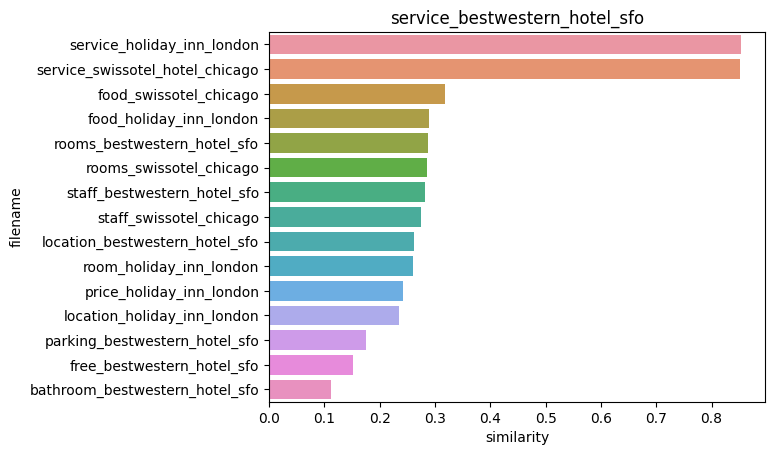

In [41]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#첫번째 문서와 타 문서 간 유사도가 큰 순으로 정렬한 인덱스를 추출하되 자기 자신 제외
sorted_index=similarity_pair.argsort()[:, ::-1]
sorted_index=sorted_index[:, 1:]

#유사도 큰 순으로 hotel_index를 추출해 재정렬
hotel_sorted_indexes=hotel_indexes[sorted_index.reshape(-1)]

#유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신 제외
hotel_1_sim_value=np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value=hotel_1_sim_value[1:]

#유사도가 큰 순으로 정렬된 인덱스와 유사도 값을 이용해 파일명과 유사도 값을 막대 그래프로 시각화
hotel_1_sim_df=pd.DataFrame()
hotel_1_sim_df['filename']=document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity']=hotel_1_sim_value

sns.barplot(x='similarity', y='filename', data=hotel_1_sim_df)
plt.title(comparison_docname)

첫 번째 문서인 service_bestwestern_hotel_sfo와 가장 비슷한 문서는 service_holiday_inn_london 이다.

##**09. 한글 텍스트 처리 - 네이버 영화 평점 감성 분석**
한글 NLP 처리에서 주의할 점과 파이썬 기반의 한글 형태소 패키지인 KoNLPy

###한글 NLP 처리의 어려움
띄어쓰기와 다양한 조사 때문에 한글 언어 처리는 어렵다. 특히 조사는 워낙 경우의 수가 많아 어근 추출 등의 전처리 시 제거가 까다롭다.

###KoNLPy 소개
대표적인 파이썬 한글 형태소 패키지. 형태소는 단어로서 의미를 갖는 최소 단위로, 형태소 분석은 말뭉치를 이러한 형태소 어근 단위로 쪼개고 각 형태소에 품사 태깅을 부착하는 작업을 지칭. 안타까운 것은 뛰어난 형태소 분석으로 인정받는 Mecab()의 경우 윈도우에서는 구동되지 않음. 리눅스 사용.

###데이터 로딩


In [42]:
import pandas as pd

train_df=pd.read_csv('ratings_train.txt', sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [43]:
#1이 긍정, 0이 부정
train_df['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

꽤 균등.

train_df의 경우 리뷰 텍스트를 갖는 document 칼럼에 일부 null이 존재하므로 공백으로 변환. 문자 아닌 숫자도 공백으로 변환. 테스트 데이터도 동일한 가공 진행하자.

In [44]:
import re

train_df=train_df.fillna(' ')
#정규 표현식을 이용해 숫자를 공백으로 변경 (정규 표현식으로 \d는 숫자를 의미)
train_df['document']=train_df['document'].apply(lambda x: re.sub(r'\d+', ' ', x))

#테스트 데이터 세트를 로딩하고 동일하게 null 및 숫자를 공백으로 변환
test_df=pd.read_csv('ratings_test.txt', sep='\t')
test_df=test_df.fillna(' ')
test_df['document']=test_df['document'].apply(lambda x: re.sub(r'\d+', ' ', x))

#id 칼럼 삭제
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

이제 tfidf 방식으로 벡터화하자.

먼거 각 문장을 한글 형태소 분석을 통해 형태소 단어로 토큰화하자.

In [47]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 36.1 MB/s eta 0:00:00


In [48]:
from konlpy.tag import Okt

# twitter = Twitter()
okt = Okt()
def tw_tokenizer(text):
  #입력 인자로 들어온 텍스트를 형태소 단어로 토큰화해 리스트 형태로 반환
  tokens_ko=okt.morphs(text)
  return tokens_ko

사이킷런의 tfidfvectorizer를 이용해 tf-idf 피처 모델을 생성하자.

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#twitter 객체의 morphs() 객체를 이용한 tokenizer 사용. ngram_range=(1,2)
tfidf_vect=TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train=tfidf_vect.transform(train_df['document'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


로지스틱 회귀로 분류 기반의 감성 분석을 수행하자.

In [50]:
#로지스틱 회귀를 이용해 감성 분석 분류 수행
lg_clf=LogisticRegression(random_state=0)

#파라미터 C의 최적화를 위해 GridSearchCV 이용
params={'C':[1, 3.5, 4.5, 5.5, 10]}

grid_cv=GridSearchCV(lg_clf, param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv.fit(tfidf_matrix_train, train_df['label'])
print(grid_cv.best_params_, round(grid_cv.best_score_, 4))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

{'C': 3.5} 0.8593


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C=3.5일 때 정확도가 0.8593으로 가장 높다.

이제 테스트 세트를 이용해 최종 감성 분석 예측을 수행하자. 테스트 세트를 이용해 예측 시 **학습할 때 적용한 tfidfvectorizer를 그대로 사용해야함**을 유의.

In [51]:
from sklearn.metrics import accuracy_score

#학습 데이터를 적용한 TfidfVectorizer를 이용해 테스트 데이터를 TF-IDF 값으로 피처 변환.
tfidf_matrix_test=tfidf_vect.transform(test_df['document'])

#classifier는 gridsearchcv에서 최적 파라미터로 학습된 calssifier를 그대로 이용
best_estimator=grid_cv.best_estimator_
preds=best_estimator.predict(tfidf_matrix_test)

print('Logistic Regression 정확도:', accuracy_score(test_df['label'], preds))

Logistic Regression 정확도: 0.86186
